<a href="https://colab.research.google.com/github/An-u-rag/computer-vision-sandbox/blob/main/mnist-mlp-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data loading

In the last exercises, we took care of the dataloading and mini-batching for you. With PyTorch, this task is considerably easier, so let's do it ourselves.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [ ]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28 at 0x7F59CCA475E0>, 5)


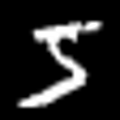

In [ ]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0), (1.0))
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a torch tensor

In [ ]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [ ]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [ ]:
#########################################################################
# Task #1: Calculate the mean and std of MNIST
# https://pytorch.org/docs/stable/
#########################################################################
mu = 0.0
std = 0.0

for img in ims_train:
  mu += img.mean()
  std += img.std()

mu /= len(ims_train)
std /= len(ims_train)
print(std)
print(mu)


tensor(0.3015)
tensor(0.1307)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 2 workers (number of subprocess that peform the dataloading. Important: you need to shuffle the training data, not the test data.

In [ ]:
#########################################################################
# Task #2: Build a dataloader for both train and test data.
#########################################################################
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=2)
dl_test = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=2)

## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises.

In [ ]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 1
nHidden = 64
act_fn = nn.ReLU()

In [ ]:
#########################################################################
# Task #3: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        ##### implement this part #####
        layers.append(nn.Linear(nInput, nHidden))
        layers.append(act_fn)
        for i in range(nLayer):
          layers.append(nn.Linear(nHidden, nHidden))
          layers.append(act_fn)
        layers.append(nn.Linear(nHidden, nOutput))
        
        ###############################
        
        layers += [nn.LogSoftmax(dim=1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [ ]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [ ]:
# Task 4: Define the device 
device = torch.device("cuda:0")

We already implemented the test function for you

In [ ]:
def test(model, dl_test, device=device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now we only need to implement the training and we are good to go

In [ ]:
#########################################################################
# Task #5: Implement the missing part of the training function. As a loss function we want to use cross-entropy
# The model already has a Log-softmax as the last layer, hence, we only need to apply the 
# negative log likelihood loss. It can be called with F.nll_loss().
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device=device):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### IMPLEMENT HERE ####
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        ##########################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

In [ ]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn).to(device)
# Task 6: Define the optimizer here
optimizer = optim.Adam(mlp.parameters(), lr = 1e-3)

In [ ]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328873
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.540282
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.341547
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.275988
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.286142
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.504941
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.285996
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.053528
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.113896
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.225026

Train set: Average loss: 0.1935, Accuracy: 54674/60000 (91.1%)


Test set: Average loss: 0.1508, Accuracy: 9538/10000 (95.380%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.261280
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.118293
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.085008
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.190546
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.057058
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.186861
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.074396
Train Epoch: 2 [44800/60000 (75%

After training, you should see test accuracies of > 97% - this is the performance we saw in our last experiments with EDF. By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

## CNN in PyTorch
Alright, we matched our prior performance. Let's surpass it!
We will build a small CNN. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|
| Log softmax (see above in MLP definition)    	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.LogSoftmax, nn.Flatten`

For layers with out parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten, F.log_softmax`

In [ ]:
class PrinterModule(nn.Module):
    def forward(x):
        print(x.shape)
        return x

In [ ]:
#########################################################################
#Task 8: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, x):
        return self.layers(x)

In [ ]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape
cnn.to("cuda:0")

CNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
    (11): LogSoftmax(dim=1)
  )
)

Alright, let's train!

In [ ]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305720
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.303870
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.310192
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.300348
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.320489
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.325141
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.329090
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.328270
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.304925
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.305226

Train set: Average loss: 2.3022, Accuracy: 4620/60000 (7.7%)


Test set: Average loss: 2.3111, Accuracy: 608/10000 (6.080%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.311572
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.321532
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.303687
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.306122
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.336029
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.346738
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.292029
Train Epoch: 2 [44800/60000 (75%)]	L